In [7]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.cuda.get_device_name(0))

True
12.4
Tesla T4


In [20]:
!pip install -r /kaggle/input/llm-data/requirements.txt 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.2/355.2 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 93.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 92.6 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 94.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.5/561.5 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━

In [8]:
import torch

def causal_mask(T: int, device=None):
    """Returns a bool mask where True means *masked* (disallowed).
    Shape: (1, 1, T, T) suitable for broadcasting with (B, heads, T, T).
    """
    m = torch.triu(torch.ones((T, T), dtype=torch.bool, device=device), diagonal=1)
    return m.view(1, 1, T, T)

In [9]:
import numpy as np

np.set_printoptions(precision=4, suppress=True)

# Toy inputs (batch=1, seq=3, d_model=4)
X = np.array([[[0.1, 0.2, 0.3, 0.4],
               [0.5, 0.4, 0.3, 0.2],
               [0.0, 0.1, 0.0, 0.1]]], dtype=np.float32)

# Weight matrices (learned in real models). We fix numbers for determinism.
Wq = np.array([[ 0.2, -0.1],
               [ 0.0,  0.1],
               [ 0.1,  0.2],
               [-0.1,  0.0]], dtype=np.float32)
Wk = np.array([[ 0.1,  0.1],
               [ 0.0, -0.1],
               [ 0.2,  0.0],
               [ 0.0,  0.2]], dtype=np.float32)
Wv = np.array([[ 0.1,  0.0],
               [-0.1,  0.1],
               [ 0.2, -0.1],
               [ 0.0,  0.2]], dtype=np.float32)

# Project to Q, K, V
Q = X @ Wq  # (1,3,2)
K = X @ Wk  # (1,3,2)
V = X @ Wv  # (1,3,2)

print("Q shape:", Q.shape, "\nQ=\n", Q[0])
print("K shape:", K.shape, "\nK=\n", K[0])
print("V shape:", V.shape, "\nV=\n", V[0])

# Scaled dot-products
scale = 1.0 / np.sqrt(Q.shape[-1])
attn_scores = (Q @ K.transpose(0,2,1)) * scale  # (1,3,3)

# Causal mask (upper triangle set to -inf so softmax->0)
mask = np.triu(np.ones((1,3,3), dtype=bool), k=1)
attn_scores = np.where(mask, -1e9, attn_scores)

# Softmax over last dim
weights = np.exp(attn_scores - attn_scores.max(axis=-1, keepdims=True))
weights = weights / weights.sum(axis=-1, keepdims=True)
print("Weights shape:", weights.shape, "\nAttention Weights (causal)=\n", weights[0])

# Weighted sum of V
out = weights @ V  # (1,3,2)
print("Output shape:", out.shape, "\nOutput=\n", out[0])

Q shape: (1, 3, 2) 
Q=
 [[ 0.01  0.07]
 [ 0.11  0.05]
 [-0.01  0.01]]
K shape: (1, 3, 2) 
K=
 [[0.07 0.07]
 [0.11 0.05]
 [0.   0.01]]
V shape: (1, 3, 2) 
V=
 [[ 0.05  0.07]
 [ 0.07  0.05]
 [-0.01  0.03]]
Weights shape: (1, 3, 3) 
Attention Weights (causal)=
 [[1.     0.     0.    ]
 [0.4994 0.5006 0.    ]
 [0.3334 0.3332 0.3334]]
Output shape: (1, 3, 2) 
Output=
 [[0.05   0.07  ]
 [0.06   0.06  ]
 [0.0367 0.05  ]]


In [21]:
import torch.nn as nn
##from multi_head import MultiHeadSelfAttention
##from ffn import FeedForward

class TransformerBlock(nn.Module):
    """1.6 Transformer block = LN → MHA → residual → LN → FFN → residual."""
    def __init__(self, d_model: int, n_head: int, dropout: float = 0.0):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.attn = MultiHeadSelfAttention(d_model, n_head, dropout)
        self.ln2 = nn.LayerNorm(d_model)
        self.ffn = FeedForward(d_model, mult=4, dropout=dropout)

    def forward(self, x):
        x = x + self.attn(self.ln1(x))[0]
        x = x + self.ffn(self.ln2(x))
        return x

In [24]:
import os
import math
import torch
##from multi_head import MultiHeadSelfAttention

OUT_TXT = os.path.join('/kaggle/working', 'mha_shapes.txt')


def log(s):
    print(s)
    with open(OUT_TXT, 'a') as f:
        f.write(s + "\n")


if __name__ == "__main__":
    # Reset file
    os.makedirs(os.path.dirname(OUT_TXT), exist_ok=True)
    open(OUT_TXT, 'w').close()

    B, T, d_model, n_head = 1, 5, 12, 3
    d_head = d_model // n_head
    x = torch.randn(B, T, d_model)
    attn = MultiHeadSelfAttention(d_model, n_head, trace_shapes=True)

    log(f"Input x:           {tuple(x.shape)} = (B,T,d_model)")
    qkv = attn.qkv(x)  # (B,T,3*d_model)
    log(f"Linear qkv(x):     {tuple(qkv.shape)} = (B,T,3*d_model)")

    qkv = qkv.view(B, T, 3, n_head, d_head)
    log(f"view to 5D:        {tuple(qkv.shape)} = (B,T,3,heads,d_head)")

    q, k, v = qkv.unbind(dim=2)
    log(f"q,k,v split:       q={tuple(q.shape)} k={tuple(k.shape)} v={tuple(v.shape)}")

    q = q.transpose(1, 2)
    k = k.transpose(1, 2)
    v = v.transpose(1, 2)
    log(f"transpose heads:   q={tuple(q.shape)} k={tuple(k.shape)} v={tuple(v.shape)} = (B,heads,T,d_head)")

    scale = 1.0 / math.sqrt(d_head)
    scores = torch.matmul(q, k.transpose(-2, -1)) * scale
    log(f"scores q@k^T:      {tuple(scores.shape)} = (B,heads,T,T)")

    weights = torch.softmax(scores, dim=-1)
    log(f"softmax(weights):  {tuple(weights.shape)} = (B,heads,T,T)")

    ctx = torch.matmul(weights, v)
    log(f"context @v:        {tuple(ctx.shape)} = (B,heads,T,d_head)")

    out = ctx.transpose(1, 2).contiguous().view(B, T, d_model)
    log(f"merge heads:       {tuple(out.shape)} = (B,T,d_model)")

    out = attn.proj(out)
    log(f"final proj:        {tuple(out.shape)} = (B,T,d_model)")

    log("\nLegend:")
    log("  B=batch, T=sequence length, d_model=embedding size, heads=n_head, d_head=d_model/heads")
    log("  qkv(x) is a single Linear producing [Q|K|V]; we reshape then split into q,k,v")

Input x:           (1, 5, 12) = (B,T,d_model)
Linear qkv(x):     (1, 5, 36) = (B,T,3*d_model)
view to 5D:        (1, 5, 3, 3, 4) = (B,T,3,heads,d_head)
q,k,v split:       q=(1, 5, 3, 4) k=(1, 5, 3, 4) v=(1, 5, 3, 4)
transpose heads:   q=(1, 3, 5, 4) k=(1, 3, 5, 4) v=(1, 3, 5, 4) = (B,heads,T,d_head)
scores q@k^T:      (1, 3, 5, 5) = (B,heads,T,T)
softmax(weights):  (1, 3, 5, 5) = (B,heads,T,T)
context @v:        (1, 3, 5, 4) = (B,heads,T,d_head)
merge heads:       (1, 5, 12) = (B,T,d_model)
final proj:        (1, 5, 12) = (B,T,d_model)

Legend:
  B=batch, T=sequence length, d_model=embedding size, heads=n_head, d_head=d_model/heads
  qkv(x) is a single Linear producing [Q|K|V]; we reshape then split into q,k,v


In [36]:
import os
import numpy as np
import matplotlib.pyplot as plt

OUT_DIR = os.path.join('/kaggle/working', 'mha.jpeg')


def _ensure_out():
    os.makedirs(OUT_DIR, exist_ok=True)


def save_matrix_heatmap(mat: np.ndarray, title: str, filename: str, xlabel: str = '', ylabel: str = ''):
    """Generic matrix heatmap saver.
    Do not set any specific colors/styles; keep defaults for clarity.
    """
    _ensure_out()
    plt.figure()
    plt.imshow(mat, aspect='auto')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
    path = os.path.join(OUT_DIR, filename)
    plt.savefig(path, bbox_inches='tight')
    plt.close()
    print(f"Saved: {path}")


def save_attention_heads_grid(weights: np.ndarray, filename: str, title_prefix: str = "Head"):
    """Plot all heads in a single grid figure (B=1 assumed).
    weights: (1, H, T, T)
    """
    _ensure_out()
    _, H, T, _ = weights.shape
    cols = min(4, H)
    rows = (H + cols - 1) // cols
    plt.figure(figsize=(3*cols, 3*rows))
    for h in range(H):
        ax = plt.subplot(rows, cols, h+1)
        ax.imshow(weights[0, h], aspect='auto')
        ax.set_title(f"{title_prefix} {h}")
        ax.set_xlabel('Key pos')
        ax.set_ylabel('Query pos')
    plt.tight_layout()
    path = os.path.join(OUT_DIR, filename)
    plt.savefig(path, bbox_inches='tight')
    print(f"Saved: {path}")
    plt.show()

Saved: /kaggle/working/mha.jpeg/multi_head_attn_grid.png


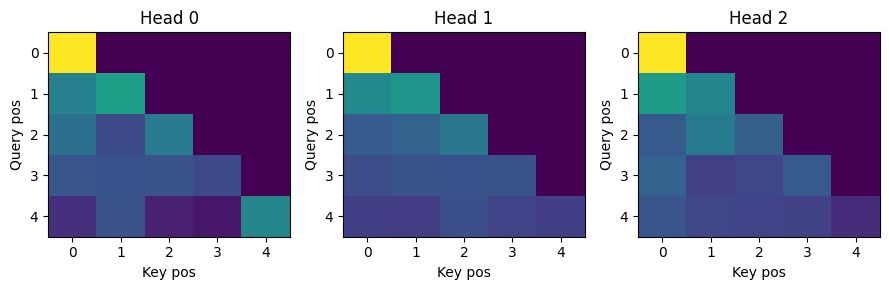

In [37]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
##from multi_head import MultiHeadSelfAttention
##from vis_utils import save_attention_heads_grid

B, T, d_model, n_head = 1, 5, 12, 3
x = torch.randn(B, T, d_model)
attn = MultiHeadSelfAttention(d_model, n_head, trace_shapes=False)

out, w = attn(x)  # w: (B, H, T, T)

save_attention_heads_grid(w.detach().cpu().numpy(), filename="multi_head_attn_grid.png")


In [34]:
import torch.nn as nn

class FeedForward(nn.Module):
    """1.5 FFN with expansion factor `mult`.

    Dimensions:
      input:     (B, T, d_model)
      inner:     (B, T, mult*d_model)
      output:    (B, T, d_model)

    `mult*d_model` means the hidden width is `mult` times larger than `d_model`.
    Typical values: mult=4 for GELU FFN in GPT-style blocks.
    """
    def __init__(self, d_model: int, mult: int = 4, dropout: float = 0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, mult * d_model),
            nn.GELU(),
            nn.Linear(mult * d_model, d_model),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

In [33]:

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
##from attn_mask import causal_mask

class MultiHeadSelfAttention(nn.Module):
    """1.4 Multi-head attention with explicit shape tracing.

    Dimensions (before masking):
      x:      (B, T, d_model)
      qkv:    (B, T, 3*d_model)
      view→   (B, T, 3, n_head, d_head)   where d_head = d_model // n_head
      split→  q,k,v each (B, T, n_head, d_head)
      swap→   (B, n_head, T, d_head)
      scores: (B, n_head, T, T) = q @ k^T / sqrt(d_head)
      weights:(B, n_head, T, T) = softmax(scores)
      ctx:    (B, n_head, T, d_head) = weights @ v
      merge:  (B, T, n_head*d_head) = (B, T, d_model)
    """
    def __init__(self, d_model: int, n_head: int, dropout: float = 0.0, trace_shapes: bool = True):
        super().__init__()
        assert d_model % n_head == 0, "d_model must be divisible by n_head"
        self.n_head = n_head
        self.d_head = d_model // n_head
        self.qkv = nn.Linear(d_model, 3 * d_model, bias=False)
        self.proj = nn.Linear(d_model, d_model, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.trace_shapes = trace_shapes

    def forward(self, x: torch.Tensor):  # (B,T,d_model)
        B, T, C = x.shape
        qkv = self.qkv(x)                          # (B,T,3*C)
        qkv = qkv.view(B, T, 3, self.n_head, self.d_head)  # (B,T,3,heads,dim)
        if self.trace_shapes:
            print("qkv view:", qkv.shape)
        q, k, v = qkv.unbind(dim=2)               # each: (B,T,heads,dim)
        q = q.transpose(1, 2)                      # (B,heads,T,dim)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)
        if self.trace_shapes:
            print("q:", q.shape, "k:", k.shape, "v:", v.shape)

        scale = 1.0 / math.sqrt(self.d_head)
        attn = torch.matmul(q, k.transpose(-2, -1)) * scale  # (B,heads,T,T)
        mask = causal_mask(T, device=x.device)
        attn = attn.masked_fill(mask, float('-inf'))
        w = F.softmax(attn, dim=-1)
        w = self.dropout(w)
        ctx = torch.matmul(w, v)                  # (B,heads,T,dim)
        if self.trace_shapes:
            print("weights:", w.shape, "ctx:", ctx.shape)
        out = ctx.transpose(1, 2).contiguous().view(B, T, C)  # (B,T,d_model)
        out = self.proj(out)
        if self.trace_shapes:
            print("out:", out.shape)
        return out, w


In [ ]:
import subprocess, sys, pathlib, argparse, shlex

ROOT = pathlib.Path(__file__).resolve().parent
OUT = ROOT / "out"


def run(cmd: str):
    print(f"\n>>> {cmd}")
    res = subprocess.run(shlex.split(cmd), cwd=ROOT)
    if res.returncode != 0:
        sys.exit(res.returncode)


def main():
    p = argparse.ArgumentParser()
    p.add_argument("--visualize", action="store_true", help="run visualization scripts and save PNGs to ./out")
    args = p.parse_args()

    OUT.mkdir(exist_ok=True)

    # 1.2 sanity check: NumPy tiny example
    run("python attn_numpy_demo.py")

    # 1.3/1.4 unit tests
    run("python -m pytest -q tests/test_attn_math.py")
    run("python -m pytest -q tests/test_causal_mask.py")

    # Matrix math walkthrough for MHA
    run("python demo_mha_shapes.py")

    if args.visualize:
        run("python demo_visualize_multi_head.py")
        print(f"\nVisualization images saved to: {OUT}")

    print("\nAll Part 1 demos/tests completed. ✅")


if __name__ == "__main__":
    main()

In [35]:
import math
import torch
import torch.nn as nn

class LearnedPositionalEncoding(nn.Module):
    def __init__(self, max_len: int, d_model: int):
        super().__init__()
        self.emb = nn.Embedding(max_len, d_model)

    def forward(self, x: torch.Tensor):
        # x: (B, T, d_model) — we only need its T and device
        B, T, _ = x.shape
        pos = torch.arange(T, device=x.device)
        pos_emb = self.emb(pos)  # (T, d_model)
        return x + pos_emb.unsqueeze(0)  # broadcast over batch

class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, max_len: int, d_model: int):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)  # (max_len, d_model)

    def forward(self, x: torch.Tensor):
        B, T, _ = x.shape
        return x + self.pe[:T].unsqueeze(0)

In [38]:
##from __future__ import annotations
##from pathlib import Path
import torch

class ByteDataset:
    """Holds raw bytes of a text file and yields (x,y) blocks for LM.
    - block_size: sequence length (context window)
    - split: fraction for training (rest is val)
    """
    def __init__(self, path: str, block_size: int = 256, split: float = 0.9):
        data = Path(path).read_bytes()
        data = torch.tensor(list(data), dtype=torch.long)
        n = int(len(data) * split)
        self.train = data[:n]
        self.val = data[n:]
        self.block_size = block_size

    def get_batch(self, which: str, batch_size: int, device: torch.device):
        buf = self.train if which == 'train' else self.val
        assert len(buf) > self.block_size + 1, 'file too small for given block_size'
        ix = torch.randint(0, len(buf) - self.block_size - 1, (batch_size,))
        x = torch.stack([buf[i:i+self.block_size] for i in ix])
        y = torch.stack([buf[i+1:i+1+self.block_size] for i in ix])
        return x.to(device), y.to(device)

In [39]:
##from __future__ import annotations
import argparse, torch
##from dataset import ByteDataset
##from model_gpt import GPT


def main():
    p = argparse.ArgumentParser()
    p.add_argument('--data', type=str, required=True)
    p.add_argument('--ckpt', type=str, required=True)
    p.add_argument('--block_size', type=int, default=256)
    p.add_argument('--batch_size', type=int, default=32)
    p.add_argument('--iters', type=int, default=100)
    p.add_argument('--cpu', action='store_true')
    args = p.parse_args()

    device = torch.device('cuda' if torch.cuda.is_available() and not args.cpu else 'cpu')

    ds = ByteDataset(args.data, block_size=args.block_size)
    ckpt = torch.load(args.ckpt, map_location=device)
    cfg = ckpt.get('config', {
        'vocab_size': 256,
        'block_size': args.block_size,
        'n_layer': 4,
        'n_head': 4,
        'n_embd': 256,
        'dropout': 0.0,
    })
    model = GPT(**cfg).to(device)
    model.load_state_dict(ckpt['model'])

    model.eval()
    losses = []
    with torch.no_grad():
        for _ in range(args.iters):
            xb, yb = ds.get_batch('val', args.batch_size, device)
            _, loss = model(xb, yb)
            losses.append(loss.item())
    print(f"val loss: {sum(losses)/len(losses):.4f}")


if __name__ == '__main__':
    main()

usage: colab_kernel_launcher.py [-h] --data DATA --ckpt CKPT
                                [--block_size BLOCK_SIZE]
                                [--batch_size BATCH_SIZE] [--iters ITERS]
                                [--cpu]
colab_kernel_launcher.py: error: the following arguments are required: --data, --ckpt


SystemExit: 2

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [41]:
##from __future__ import annotations
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

# ---- Blocks (self-contained for isolation) ----
class CausalSelfAttention(nn.Module):
    def __init__(self, n_embd: int, n_head: int, dropout: float = 0.0):
        super().__init__()
        assert n_embd % n_head == 0
        self.n_head = n_head
        self.d_head = n_embd // n_head
        self.qkv = nn.Linear(n_embd, 3 * n_embd, bias=False)
        self.proj = nn.Linear(n_embd, n_embd, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor):  # (B,T,C)
        B, T, C = x.shape
        qkv = self.qkv(x).view(B, T, 3, self.n_head, self.d_head)
        q, k, v = qkv.unbind(dim=2)
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)
        scale = 1.0 / math.sqrt(self.d_head)
        # PyTorch SDPA (uses flash when available)
        y = F.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout.p if self.training else 0.0, is_causal=True)
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.proj(y)
        return y

class FeedForward(nn.Module):
    def __init__(self, n_embd: int, mult: int = 4, dropout: float = 0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, mult * n_embd),
            nn.GELU(),
            nn.Linear(mult * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, n_embd: int, n_head: int, dropout: float):
        super().__init__()
        self.ln1 = nn.LayerNorm(n_embd)
        self.attn = CausalSelfAttention(n_embd, n_head, dropout)
        self.ln2 = nn.LayerNorm(n_embd)
        self.ffn = FeedForward(n_embd, mult=4, dropout=dropout)

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.ffn(self.ln2(x))
        return x

# ---- Tiny GPT ----
class GPT(nn.Module):
    def __init__(self, vocab_size: int, block_size: int, n_layer: int = 4, n_head: int = 4, n_embd: int = 256, dropout: float = 0.0):
        super().__init__()
        self.block_size = block_size
        self.tok_emb = nn.Embedding(vocab_size, n_embd)
        self.pos_emb = nn.Embedding(block_size, n_embd)
        self.drop = nn.Dropout(dropout)
        self.blocks = nn.ModuleList([Block(n_embd, n_head, dropout) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.head = nn.Linear(n_embd, vocab_size, bias=False)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, mean=0.0, std=0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Embedding):
            nn.init.normal_(m.weight, mean=0.0, std=0.02)

    def forward(self, idx: torch.Tensor, targets: torch.Tensor | None = None):
        B, T = idx.shape
        assert T <= self.block_size
        pos = torch.arange(0, T, device=idx.device).unsqueeze(0)
        x = self.tok_emb(idx) + self.pos_emb(pos)
        x = self.drop(x)
        for blk in self.blocks:
            x = blk(x)
        x = self.ln_f(x)
        logits = self.head(x)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

    @torch.no_grad()
    def generate(self, idx: torch.Tensor, max_new_tokens: int = 200, temperature: float = 1.0,
                top_k: int | None = 50, top_p: float | None = None):
        from utils import top_k_top_p_filtering
        self.eval()
        # Guard: if the prompt is empty, start with a newline byte (10)
        if idx.size(1) == 0:
            idx = torch.full((idx.size(0), 1), 10, dtype=torch.long, device=idx.device)
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / max(temperature, 1e-6)
            logits = top_k_top_p_filtering(logits, top_k=top_k, top_p=top_p)
            probs = torch.softmax(logits, dim=-1)
            next_id = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, next_id], dim=1)
        return idx

In [48]:

import argparse, time
import torch



def estimate_loss(model: GPT, ds: ByteDataset, args) -> dict:
    model.eval()
    out = {}
    with torch.no_grad():
        for split in ['train', 'val']:
            losses = []
            for _ in range(args.eval_iters):
                xb, yb = ds.get_batch(split, args.batch_size, args.device)
                _, loss = model(xb, yb)
                losses.append(loss.item())
            out[split] = sum(losses) / len(losses)
    model.train()
    return out


def train():
    model.eval()
    out = {}
    with torch.no_grad():
        for split in ['train', 'val']:
            losses = []
            for _ in range(args.eval_iters):
                xb, yb = ds.get_batch(split, args.batch_size, args.device)
                _, loss = model(xb, yb)
                losses.append(loss.item())
            out[split] = sum(losses) / len(losses)
    model.train()
    return out
    p = argparse.ArgumentParser()
    p.add_argument('--data', type=str, required=True)
    p.add_argument('--out_dir', type=str, default='runs/min-gpt')
    p.add_argument('--block_size', type=int, default=256)
    p.add_argument('--batch_size', type=int, default=32)
    p.add_argument('--n_layer', type=int, default=4)
    p.add_argument('--n_head', type=int, default=4)
    p.add_argument('--n_embd', type=int, default=256)
    p.add_argument('--dropout', type=float, default=0.0)
    p.add_argument('--steps', type=int, default=2000)
    p.add_argument('--lr', type=float, default=3e-4)
    p.add_argument('--weight_decay', type=float, default=0.1)
    p.add_argument('--grad_clip', type=float, default=1.0)
    p.add_argument('--eval_interval', type=int, default=200)
    p.add_argument('--eval_iters', type=int, default=50)
    p.add_argument('--sample_every', type=int, default=200)
    p.add_argument('--sample_tokens', type=int, default=256)
    p.add_argument('--temperature', type=float, default=1.0)
    p.add_argument('--top_k', type=int, default=50)
    p.add_argument('--top_p', type=float, default=None)
    p.add_argument('--cpu', action='store_true')
    p.add_argument('--compile', action='store_true')
    p.add_argument('--amp', action='store_true')
    args = p.parse_args()

    args.device = torch.device('cuda' if torch.cuda.is_available() and not args.cpu else 'cpu')

    tok = ByteTokenizer()
    ds = ByteDataset(args.data, block_size=args.block_size)
    model = GPT(tok.vocab_size, args.block_size, args.n_layer, args.n_head, args.n_embd, args.dropout).to(args.device)

    if args.compile and hasattr(torch, 'compile'):
        model = torch.compile(model)

    opt = torch.optim.AdamW(model.parameters(), lr=args.lr, betas=(0.9, 0.95), weight_decay=args.weight_decay)
    scaler = torch.cuda.amp.GradScaler(enabled=(args.amp and args.device.type == 'cuda'))

    best_val = float('inf')
    t0 = time.time()
    model.train()
    for step in range(1, args.steps + 1):
        xb, yb = ds.get_batch('train', args.batch_size, args.device)
        with torch.cuda.amp.autocast(enabled=(args.amp and args.device.type == 'cuda')):
            _, loss = model(xb, yb)
        opt.zero_grad(set_to_none=True)
        scaler.scale(loss).backward()
        if args.grad_clip > 0:
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.grad_clip)
        scaler.step(opt)
        scaler.update()

        if step % 50 == 0:
            print(f"step {step:5d} | loss {loss.item():.4f} | {(time.time()-t0):.1f}s")
            t0 = time.time()

        if step % args.eval_interval == 0:
            losses = estimate_loss(model, ds, args)
            print(f"eval | train {losses['train']:.4f} | val {losses['val']:.4f}")
            if losses['val'] < best_val:
                best_val = losses['val']
                ckpt_path = f"{args.out_dir}/model_best.pt"
                import os; os.makedirs(args.out_dir, exist_ok=True)
                torch.save({'model': model.state_dict(), 'config': {
                    'vocab_size': tok.vocab_size,
                    'block_size': args.block_size,
                    'n_layer': args.n_layer,
                    'n_head': args.n_head,
                    'n_embd': args.n_embd,
                    'dropout': args.dropout,
                }}, ckpt_path)
                print(f"saved checkpoint: {ckpt_path}")

        if args.sample_every > 0 and step % args.sample_every == 0:
            start = torch.randint(low=0, high=len(ds.train) - args.block_size - 1, size=(1,)).item()
            seed = ds.train[start:start + args.block_size].unsqueeze(0).to(args.device)
            out = model.generate(seed, max_new_tokens=args.sample_tokens, temperature=args.temperature, top_k=args.top_k, top_p=args.top_p)
            txt = tok.decode(out[0].cpu())
            print("\n================ SAMPLE ================\n" + txt[-(args.block_size + args.sample_tokens):] + "\n=======================================\n")

    # final save
    import os; os.makedirs(args.out_dir, exist_ok=True)
    torch.save({'model': model.state_dict()}, f"{args.out_dir}/model_final.pt")




In [ ]:


import argparse, torch



def sample():
    p = argparse.ArgumentParser()
    p.add_argument('--ckpt', type=str, required=True)
    p.add_argument('--prompt', type=str, default='')
    p.add_argument('--tokens', type=int, default=200)
    p.add_argument('--temperature', type=float, default=1.0)
    p.add_argument('--top_k', type=int, default=50)
    p.add_argument('--top_p', type=float, default=None)
    p.add_argument('--cpu', action='store_true')
    args = p.parse_args()

    device = torch.device('cuda' if torch.cuda.is_available() and not args.cpu else 'cpu')

    tok = ByteTokenizer()
    prompt_ids = tok.encode(args.prompt).unsqueeze(0).to(device)
    if prompt_ids.numel() == 0:
        # If no prompt provided, seed with newline byte (10)
        prompt_ids = torch.tensor([[10]], dtype=torch.long, device=device)


    ckpt = torch.load(args.ckpt, map_location=device)
    config = ckpt.get('config', None)

    if config is None:
        # fall back to defaults
        model = GPT(tok.vocab_size, block_size=256).to(device)
        model.load_state_dict(ckpt['model'])
    else:
        model = GPT(**config).to(device)
        model.load_state_dict(ckpt['model'])

    with torch.no_grad():
        out = model.generate(prompt_ids, max_new_tokens=args.tokens, temperature=args.temperature, top_k=args.top_k, top_p=args.top_p)
    print(tok.decode(out[0].cpu()))




In [ ]:

from __future__ import annotations
import argparse, torch
from dataset import ByteDataset
from model_gpt import GPT


def eval_loss():
    p = argparse.ArgumentParser()
    p.add_argument('--data', type=str, required=True)
    p.add_argument('--ckpt', type=str, required=True)
    p.add_argument('--block_size', type=int, default=256)
    p.add_argument('--batch_size', type=int, default=32)
    p.add_argument('--iters', type=int, default=100)
    p.add_argument('--cpu', action='store_true')
    args = p.parse_args()

    device = torch.device('cuda' if torch.cuda.is_available() and not args.cpu else 'cpu')

    ds = ByteDataset(args.data, block_size=args.block_size)
    ckpt = torch.load(args.ckpt, map_location=device)
    cfg = ckpt.get('config', {
        'vocab_size': 256,
        'block_size': args.block_size,
        'n_layer': 4,
        'n_head': 4,
        'n_embd': 256,
        'dropout': 0.0,
    })
    model = GPT(**cfg).to(device)
    model.load_state_dict(ckpt['model'])

    model.eval()
    losses = []
    with torch.no_grad():
        for _ in range(args.iters):
            xb, yb = ds.get_batch('val', args.batch_size, device)
            _, loss = model(xb, yb)
            losses.append(loss.item())
    print(f"val loss: {sum(losses)/len(losses):.4f}")



In [43]:
import subprocess, sys, pathlib, shlex

ROOT = pathlib.Path('/kaggle/input/llm-data/tiny.txt').resolve().parent
RUNS = ROOT / 'runs' / 'min-gpt'

def run(cmd: str):
    print(f"\n>>> {cmd}")
    res = subprocess.run(shlex.split(cmd), cwd=ROOT)
    if res.returncode != 0:
        sys.exit(res.returncode)

if __name__ == '__main__':
    # quick smoke training on a tiny file path tiny_hi.txt; adjust as needed
    run("python train.py --data tiny_hi.txt --steps 400 --sample_every 100 --eval_interval 100 --batch_size 32 --block_size 128 --n_layer 2 --n_head 2 --n_embd 128")

    # sample from the best checkpoint
    run(f"python sample.py --ckpt {RUNS}/model_best.pt --tokens 200 --prompt 'Once upon a time '")

    # evaluate final val loss
    run(f"python eval_loss.py --data tiny_hi.txt --ckpt {RUNS}/model_best.pt --iters 50 --block_size 128")
  


>>> python train.py --data tiny_hi.txt --steps 400 --sample_every 100 --eval_interval 100 --batch_size 32 --block_size 128 --n_layer 2 --n_head 2 --n_embd 128


python3: can't open file '/kaggle/input/llm-data/train.py': [Errno 2] No such file or directory


SystemExit: 2

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
